In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# important global variables
nYears = 1
throughgoing_factor = 1 # don't consider it
wobbling_factor = 1 # 1 / 0.01 # no wobble!

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('figures.mplstyle')

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

from global_variables import *
from lv import *
from flux import *

from scipy.interpolate import interp1d
from scipy.stats import norm
import vegas
from functools import partial

In [4]:
# Rate of neutrino interactions / dR / dE
# Units: (Number of Interactions) / m / GeV
def rate(flux, xsec, Enu, R, P, baseline):
    costh = np.cos(R/baseline)
    ret = flux(Emuon, P, Enu, costh, baseline)*xsec(Enu)*MASS*(4*np.pi*R*np.sqrt(RADIUS**2 - R**2)/VOLUME)
    if not isinstance(ret, float):
        ret[R > RADIUS] = 0
    elif R > RADIUS:
        return 0
    return ret

def integrand_dump(x, baseline):
    Enu, R = x  # x will be a 2D vector [Enu, R]
    return rate(numu_flux_dump, xsec, Enu, R, P, baseline)

def integrand_accelerator(x, baseline):
    Enu, R = x  # x will be a 2D vector [Enu, R]
    return rate(numu_flux_accelerator, xsec, Enu, R, P, baseline)

def energy_integrand_dump(x, baseline):
    Enu, R = x  # x will be a 2D vector [Enu, R]
    return Enu*rate(numu_flux_dump, xsec, Enu, R, P, baseline)

def energy_integrand_accelerator(x, baseline):
    Enu, R = x  # x will be a 2D vector [Enu, R]
    return Enu*rate(numu_flux_accelerator, xsec, Enu, R, P, baseline)

# Perform the integration over specified ranges
def perform_integration(experiment):
    # Define the ranges for Enu and R
    Enu_min, Enu_max = Emuon/10, Emuon  # Replace with actual range
    R_min, R_max = 0.0, RADIUS  # Ensure R is within the allowed radius

    if experiment == "PONE":
        integrand = integrand_accelerator
    else:
        integrand = integrand_dump
    
    # Set up the integrator
    integ = vegas.Integrator([[Enu_min, Enu_max], [R_min, R_max]])

    integrand_partial = partial(integrand, baseline=baseline_list[experiment])
    
    # Perform the integration
    result = integ(integrand_partial, nitn=20, neval=1000)
    #print(result.summary())
    return result.val

def average_energy(experiment):
    # Define the ranges for Enu and R
    Enu_min, Enu_max = Emuon/10, Emuon  # Replace with actual range
    R_min, R_max = 0.0, RADIUS  # Ensure R is within the allowed radius

    if experiment == "PONE":
        integrand = integrand_accelerator
        energy_integrand = energy_integrand_accelerator
    else:
        integrand = integrand_dump
        energy_integrand = energy_integrand_dump
    
    # Set up the integrator
    integ = vegas.Integrator([[Enu_min, Enu_max], [R_min, R_max]])

    energy_integrand_partial = partial(energy_integrand, baseline=baseline_list[experiment])
    total_integrand_partial = partial(integrand, baseline=baseline_list[experiment])
    
    # Perform the integration
    energy_result = (integ(energy_integrand_partial, nitn=20, neval=1000)).val
    total_result = (integ(total_integrand_partial, nitn=20, neval=1000)).val
    return energy_result/total_result


In [5]:


nEvents_dict = {"IC":perform_integration("IC")*nYears*throughgoing_factor,
                "KM3":perform_integration("KM3")*nYears*throughgoing_factor,
                "PONE":perform_integration("PONE")*nYears*throughgoing_factor}
avg_energy_dict = {"IC":average_energy("IC"),
                   "KM3":average_energy("KM3"),
                   "PONE":average_energy("PONE")}
for k,v in nEvents_dict.items():
    print(k,"%1.1f Hz, %1.1e/yr"%(v/(nYears*S2YR),v/nYears))
nTrials = int(1e5)
highest_mode = 5
nBins = int(2**highest_mode)+1
t_bins = np.linspace(0,1,nBins+1)
t_bin_centers = (t_bins[1:] + t_bins[:-1])/2

def get_amplitudes(events):
    fft = np.abs(np.fft.fft(events))
    amps = np.zeros(nBins)
    amps[0] = fft[0]/nBins
    amps[1:] = 2*fft[1:]/nBins
    amps /= amps[0]
    return amps


IC 4.9 Hz, 1.6e+08/yr
KM3 5.2 Hz, 1.6e+08/yr
PONE 4266.1 Hz, 1.3e+11/yr


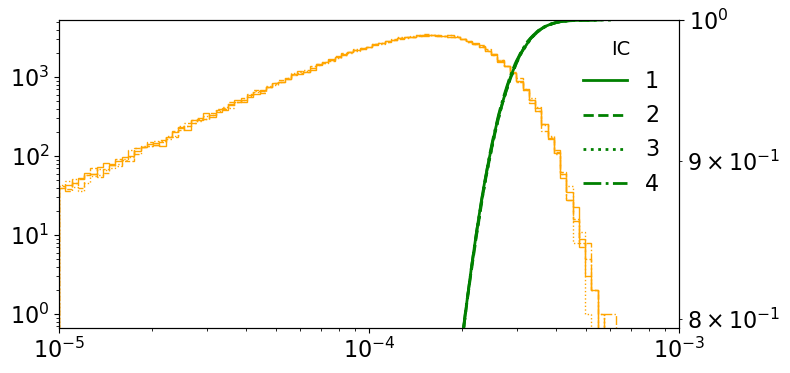

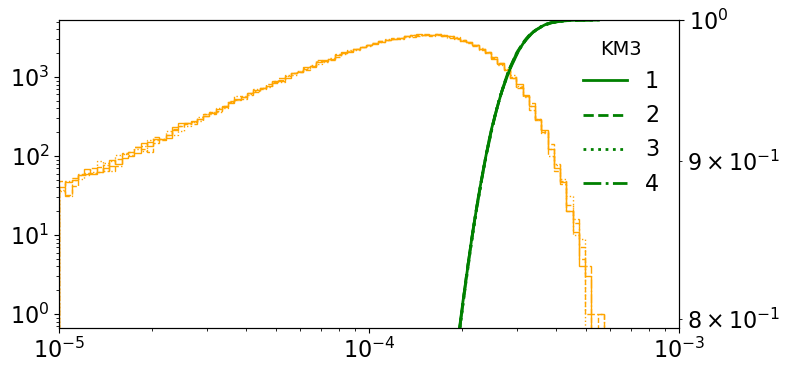

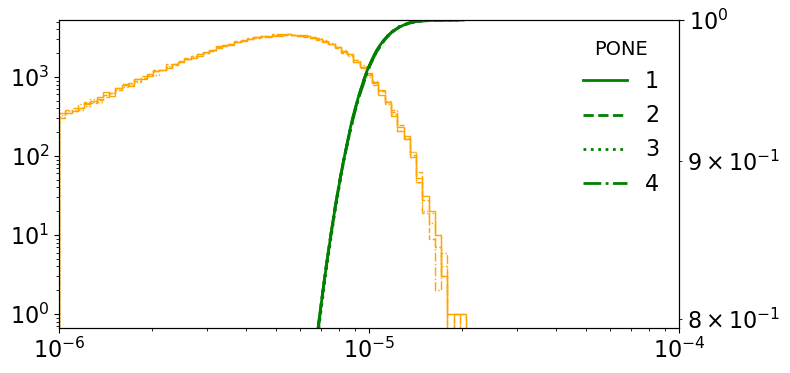

In [6]:
amplitudes = {}
quantile_points = np.logspace(-0.1,0,nTrials)
sensitivity_quantiles = [1-((1-norm.cdf(n))*2) for n in [1,2,3,4]]
sensitivity_quantiles += [0.9]
exp_sensitivities = {}
amplitude_bins = np.logspace(-5,-3,100)
for exp,nEvents in nEvents_dict.items():
    amplitude_bins = np.logspace(-5,-3,100)
    if exp=="PONE": amplitude_bins /= 10
    amps = np.empty((nTrials,nBins))
    poisson_throws = np.random.poisson(nEvents/(nBins),(nTrials,nBins))
    for nT,n in enumerate(poisson_throws):
        amps[nT] = get_amplitudes(n)
        # fft = np.abs(np.real(np.fft.fft(n)))
        # amps[nT][0] = fft[0]/nBins
        # amps[nT][1:] = 2*fft[1:]/nBins
        # amps[nT] /= amps[nT][0]
    amplitudes[exp] = amps
    
    fig = plt.figure()
    ax1 = plt.gca()
    ax2 = plt.gca().twinx()
    for mode,ls in zip([1,2,3,4],["-","--",":","-."]):
        ax1.hist(amps[:,mode],color="orange",bins=amplitude_bins,ls=ls,histtype="step")
        
        quantiles = np.quantile(amps[:,mode],quantile_points)
        ax2.plot(quantiles,quantile_points,color="green",ls=ls,label=mode)
        exp_sens = np.quantile(amps[:,mode],sensitivity_quantiles)
        exp_sensitivities[(exp,mode)] = {quant:sens for quant,sens in zip(sensitivity_quantiles,exp_sens)}
    ax1.set_xscale("log")
    ax2.set_xscale("log")
    ax1.set_xlim(amplitude_bins[0],amplitude_bins[-1])
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax2.set_ylim(quantile_points[0],quantile_points[-1])
    plt.legend(title=exp)
    plt.show()
    plt.close(fig)



## but how does amplitude correspond to PSD?

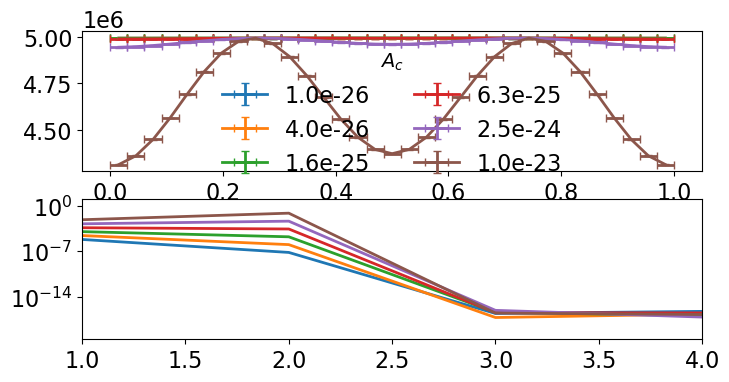

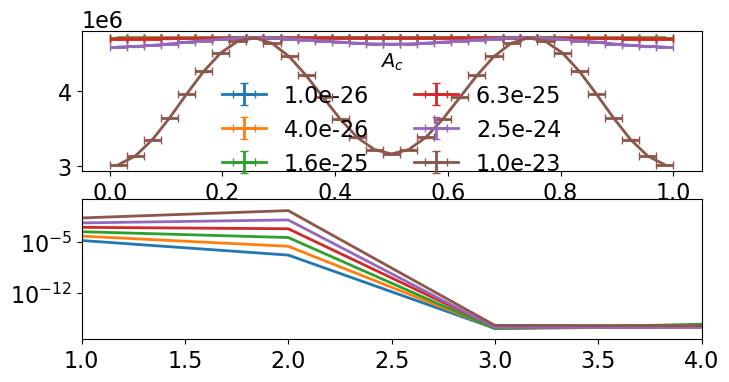

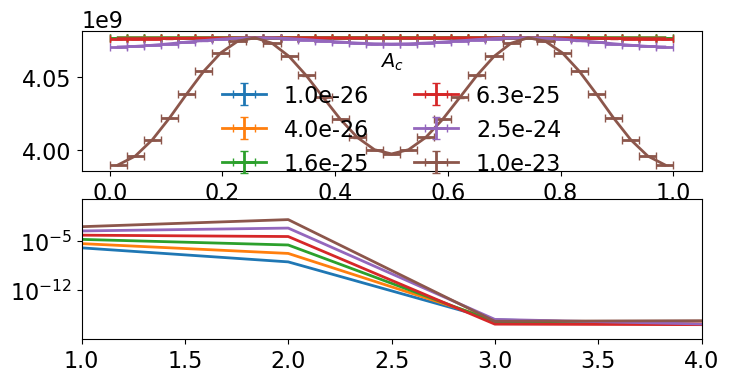

In [7]:
Ac_list = np.logspace(-26,-23,6)
mode2_amps = {}
for exp in experiment_list:
    amp = np.empty(int(nBins/2-1))
    fig,ax = plt.subplots(2,1)
    mode2_amps[exp] = []
    for Ac in Ac_list:
        events = (nEvents_dict[exp]/nBins)*osc_prob(baseline_list[exp],t_bin_centers,Ac=Ac)
        # fft = np.abs(np.abs(np.fft.fft(events)))[:int(nBins/2)-1]
        # amp[0] = fft[0]/nBins
        # amp[1:] = 2*fft[1:]/nBins
        # amp/= amp[0]
        amp = get_amplitudes(events)
        mode2_amps[exp].append(amp[2])
        ax[0].errorbar(t_bin_centers,events,xerr=(t_bins[1]-t_bins[0])/2,yerr=np.sqrt(events),capsize=3,label="%1.1e"%Ac)
        ax[1].plot(amp)
    ax[0].legend(ncol=2,title=r"$A_c$")
    #ax[0].semilogy()
    ax[1].semilogy()
    #ax[1].set_ylim(1e-6,1e-2)
    ax[1].set_xlim(1,4)
    plt.show()
    plt.close(fig)



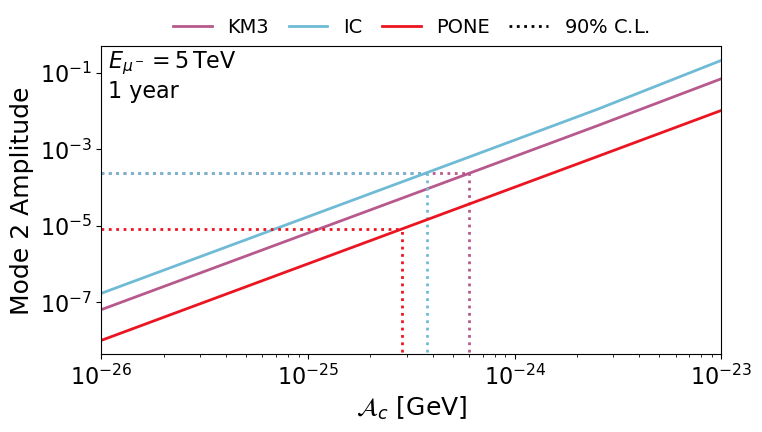

In [8]:
Ac_upper_limit = {}
for exp in experiment_list:
    plt.plot(Ac_list,mode2_amps[exp],label=exp,color=color_list[exp])
    for quantile in sensitivity_quantiles:
        Ac_interp = interp1d(np.log10(mode2_amps[exp]),np.log10(Ac_list))
        amp_upper_limit = exp_sensitivities[(exp,2)][quantile]
        Ac_upper_limit[(exp,quantile)] = 10**Ac_interp(np.log10(amp_upper_limit))
        if quantile == sensitivity_quantiles[-1]:
            plt.plot([Ac_list[0],Ac_upper_limit[(exp,quantile)]],
                     [amp_upper_limit,amp_upper_limit],
                     color=color_list[exp],ls=":")
            plt.plot([Ac_upper_limit[(exp,quantile)],Ac_upper_limit[(exp,quantile)]],
                     [0,amp_upper_limit],
                     color=color_list[exp],ls=":")
plt.xlabel(r"$\mathcal{A}_c~[{\rm GeV}]$")
plt.ylabel("Mode 2 Amplitude")
plt.loglog()
plt.xlim(Ac_list[0],Ac_list[-1])
plt.text(.01, .99, r"$E_{\mu^-} = %d\,{\rm TeV}$"%(Emuon/1e3), ha='left', va='top', transform=plt.gca().transAxes,fontsize=16)
if nYears==1: plt.text(.01, .89, r"%d year"%(nYears), ha='left', va='top', transform=plt.gca().transAxes,fontsize=16)
else: plt.text(.01, .89, r"%d years"%(nYears), ha='left', va='top', transform=plt.gca().transAxes,fontsize=16)
plt.plot([],[],ls=":",label=r"$90\%$ C.L.",color="black")
plt.legend(ncol=5, fontsize=14, columnspacing=1, frameon=False,
           loc='upper center', bbox_to_anchor=(0.5, 1.15))
plt.savefig("figures/%dTeV/Ac_sensitivity.pdf"%(Emuon/1e3),dpi=100,bbox_inches='tight')
plt.show()

In [9]:
print("Dimension",end=" & ")
for exp in experiment_list:
    print(experiment_names[exp],end=" & ")
print("")
for dim in range(4):
    print("$d=%d$"%dim,end=" & ")
    for exp in experiment_list:
        Ac_limit = Ac_upper_limit[(exp,sensitivity_quantiles[-1])] / avg_energy_dict[exp]**dim
        print("$%s$"%latex_float(Ac_limit),end=" & ")
    print("")

Dimension & KM3NeT & IceCube & P-ONE & 
$d=0$ & $6 \times 10^{-25}$ & $3.7 \times 10^{-25}$ & $2.8 \times 10^{-25}$ & 
$d=1$ & $2.3 \times 10^{-28}$ & $1.4 \times 10^{-28}$ & $1.1 \times 10^{-28}$ & 
$d=2$ & $9 \times 10^{-32}$ & $5.4 \times 10^{-32}$ & $4.2 \times 10^{-32}$ & 
$d=3$ & $3.5 \times 10^{-35}$ & $2.1 \times 10^{-35}$ & $1.6 \times 10^{-35}$ & 


# Now in terms of the bare LIV coefficients

/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_11096/1262506213.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_inset = plt.gca().inset_axes([0.5, 0.76, 0.45, 0.2],


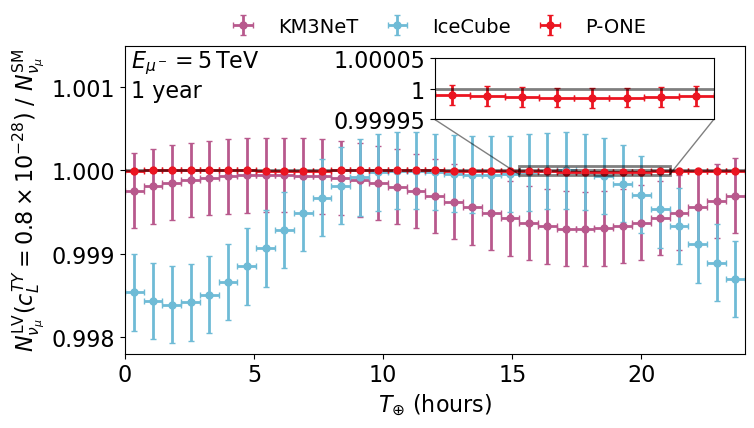

In [10]:

fig = plt.figure()
ax = plt.gca()
aL_vec = np.zeros(4,dtype=float)
cL_vec = np.zeros((4,4),dtype=float)
if Emuon==5e3:
    cL_vec[0,2] = 0.8e-28 # for example
    plt.ylim(0.9978,1.0015)
elif Emuon==20e3:
    cL_vec[0,1] = 2e-29
    plt.ylim(0.9992,1.0005)
#aL_vec[3] = 2e-23 # for example
LVsv = LV_sidreal_variations(aL_vec,cL_vec)
plot_lines = []
test_amplitudes = {}
for exp in experiment_list:
    C,As,Ac,Bs,Bc = LVsv.get_coefficients(exp,Emean=avg_energy_dict[exp])
    nominal = (nEvents_dict[exp]/nBins)
    events = (nEvents_dict[exp]/nBins)*osc_prob(baseline_list[exp],
                                                t_bin_centers,
                                                C=C,
                                                Ac=Ac,As=As,
                                                Bc=Bc,Bs=Bs)
    test_amplitudes[exp] = get_amplitudes(events)
    plot_lines.append(
        plt.errorbar(t_bin_centers*24,events/nominal,xerr=24*(t_bins[1]-t_bins[0])/2,yerr=np.sqrt(events)/nominal,
                     color=color_list[exp],capsize=2,label=exp,fmt=".")
    )
plt.plot([0,24],[1,1],color="black",alpha=0.5,ls="-")
plt.xlim(0,24)

#plt.semilogy()
plt.xlabel(r"$T_{\oplus}$ (hours)",fontsize=16)
if Emuon==5e3:
    plt.ylabel(r"$N^{\rm LV}_{\nu_\mu}(c_L^{TY} = %1.1f \times 10^{-28})~/~N^{\rm SM}_{\nu_\mu}$"%(cL_vec[0,2]/1e-28),fontsize=16)
    # Define the limits for the inset (zoomed-in section)
    x1, x2, y1, y2 = 24*t_bins[21], 24*t_bins[29], 0.99995, 1.00005
elif Emuon==25e3:
    plt.ylabel(r"$N^{\rm LV}_{\nu_\mu}(c_L^{TY} = %1.1f \times 10^{-29})~/~N^{\rm SM}_{\nu_\mu}$"%(cL_vec[0,2]/1e-29),fontsize=16)
    # Define the limits for the inset (zoomed-in section)
    x1, x2, y1, y2 = 24*t_bins[13], 24*t_bins[21], 0.99998, 1.00002
p0 = plt.plot([],[])
plt.legend(plot_lines,[experiment_names[exp] for exp in experiment_list], 
            ncol=3, fontsize=14, columnspacing=1, frameon=False,
            loc='upper center', bbox_to_anchor=(0.5, 1.15))

plt.text(.01, .99, r"$E_{\mu^-} = %d\,{\rm TeV}$"%(Emuon/1e3), ha='left', va='top', transform=plt.gca().transAxes,fontsize=16)
if nYears==1: plt.text(.01, .89, r"%d year"%(nYears), ha='left', va='top', transform=plt.gca().transAxes,fontsize=16)
else: plt.text(.01, .89, r"%d years"%(nYears), ha='left', va='top', transform=plt.gca().transAxes,fontsize=16)


# zoomed in axis



# Add an inset axes
ax_inset = plt.gca().inset_axes([0.5, 0.76, 0.45, 0.2],
                                xlim=(x1, x2),ylim=(y1, y2),
                                xticklabels=[],
                                yticklabels=[y1,1,y2],
                                xticks=[],
                                yticks=[y1,1,y2]
                               )


ax_inset.set_xlim(x1, x2)
ax_inset.set_ylim(y1, y2)

exp = "PONE"
C,As,Ac,Bs,Bc = LVsv.get_coefficients(exp,Emean=avg_energy_dict[exp])
nominal = (nEvents_dict[exp]/nBins)
events = (nEvents_dict[exp]/nBins)*osc_prob(baseline_list[exp],
                                            t_bin_centers,
                                            C=C,
                                            Ac=Ac,As=As,
                                            Bc=Bc,Bs=Bs)
test_amplitudes[exp] = get_amplitudes(events)
ax_inset.errorbar(t_bin_centers*24,events/nominal,xerr=24*(t_bins[1]-t_bins[0])/2,yerr=np.sqrt(events)/nominal,
             color=color_list[exp],capsize=2,fmt=".")
ax_inset.plot([x1,x2],[1,1],color="black",alpha=0.5,ls="-")

ax.indicate_inset_zoom(ax_inset, edgecolor="black",lw=2)


plt.savefig("figures/%dTeV/LV_sidereal.pdf"%(Emuon/1e3),dpi=100,bbox_inches='tight')
plt.show()

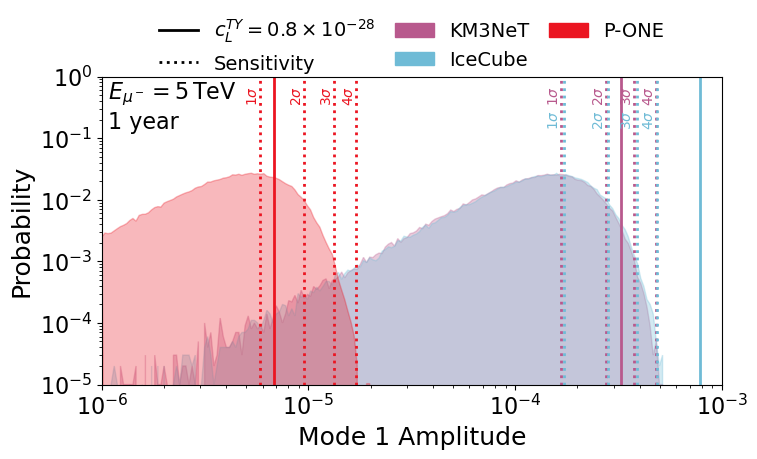

In [11]:
mode = 1
if Emuon==5e3:
    amplitude_bins = np.logspace(-6,-3,200)
elif Emuon==20e3:
    amplitude_bins = np.logspace(-6.5,-3.3,200)
amplitdue_bw = amplitude_bins[1:] - amplitude_bins[:-1]
if Emuon==5e3:
    plt.plot([],[],color="black",ls="-",label=r"$c_L^{TY} = %1.1f \times 10^{-28}$"%(cL_vec[0,2]/1e-28))
elif Emuon==20e3:
    plt.plot([],[],color="black",ls="-",label=r"$c_L^{TY} = %1.1f \times 10^{-29}$"%(cL_vec[0,2]/1e-29))
plt.plot([],[],color="black",ls=":",label="Sensitivity")
for exp in experiment_list:
    rates,_ = np.histogram(amplitudes[exp][:,mode],bins=amplitude_bins)
    y = 1.*rates#/amplitdue_bw
    y /= sum(y)
    plt.fill([],[],color=color_list[exp],label=experiment_names[exp])
    plt.fill(amplitude_bins[:-1],y,color=color_list[exp],alpha=0.3)
    plt.axvline(test_amplitudes[exp][mode],color=color_list[exp])
    for sens_level_idx in range(4):
        sens_level = sensitivity_quantiles[sens_level_idx]
        plt.axvline(exp_sensitivities[(exp,mode)][sens_level],color=color_list[exp],ls=":")
        height = 5e-1
        x = exp_sensitivities[(exp,mode)][sens_level]
        if exp=="IC":
            height = 2e-1
            x = exp_sensitivities[("KM3",mode)][sens_level]
        plt.text(x,height,r"$%d\sigma$"%(sens_level_idx+1),
                 horizontalalignment='right', verticalalignment='center', 
                 color=color_list[exp],rotation=90)
plt.xlim(amplitude_bins[0],amplitude_bins[-1])
plt.loglog()
plt.ylim(1e-5,1)
plt.ylabel("Probability")
plt.xlabel("Mode %d Amplitude"%mode)
plt.text(.01, .99, r"$E_{\mu^-} = %d\,{\rm TeV}$"%(Emuon/1e3), ha='left', va='top', transform=plt.gca().transAxes,fontsize=16)
plt.text(.01, .89, r"%d year"%(nYears), ha='left', va='top', transform=plt.gca().transAxes,fontsize=16)

plt.legend(ncol=3, fontsize=14, columnspacing=1, frameon=False,
            loc='upper center', bbox_to_anchor=(0.5, 1.25))

plt.savefig("figures/%dTeV/amplitude_dist.pdf"%(Emuon/1e3),dpi=100,bbox_inches='tight')
plt.show()

In [12]:
aL_range = np.logspace(-26.5,-22.9,30)
cL_range = np.logspace(-30.5,-26.1,30)
aL_amps = {}
cL_amps = {}
for aL in aL_range:
    for pos in range(4):
        aL_vec = np.zeros(4)
        aL_vec[pos] = aL
        LVsv = LV_sidreal_variations(aL_vec,np.zeros((4,4)))
        for exp in experiment_list:
            C,As,Ac,Bs,Bc = LVsv.get_coefficients(exp,Emean=avg_energy_dict[exp])
            events = (nEvents_dict[exp]/nBins)*osc_prob(baseline_list[exp],
                                              t_bin_centers,
                                              C=C,
                                              Ac=Ac,As=As,
                                              Bc=Bc,Bs=Bs)
            aL_amps[(exp,pos,aL)] = get_amplitudes(events)

for cL in cL_range:
    for pos1 in range(4):
        for pos2 in range(4):
            cL_vec = np.zeros((4,4))
            cL_vec[pos1,pos2] = cL
            LVsv = LV_sidreal_variations(np.zeros(4),cL_vec)
            for exp in experiment_list:
                C,As,Ac,Bs,Bc = LVsv.get_coefficients(exp,Emean=avg_energy_dict[exp])
                events = (nEvents_dict[exp]/nBins)*osc_prob(baseline_list[exp],
                                                  t_bin_centers,
                                                  C=C,
                                                  Ac=Ac,As=As,
                                                  Bc=Bc,Bs=Bs)
                cL_amps[(exp,pos1,pos2,cL)] = get_amplitudes(events)


            
            #nominal = (nEvents_dict[exp]/nBins)
        
    #     plt.errorbar(t_bin_centers,events/nominal - 1,xerr=(t_bins[1]-t_bins[0])/2,yerr=np.sqrt(events)/nominal,capsize=3,label=exp,fmt='.')
    # plt.plot([0,1],[0,0],color="grey",ls="-")
    # plt.ylabel("(LV - SM)/SM")
    # plt.xlabel(r"Local Sidereal Phase")
    # plt.legend(title=r"$\mathcal{A}_c/(10^{-21}) = %1.1f$"%(Ac/1e-21))
    # plt.xlim(0,1)
    # plt.show()

Warning! We are not in the short baseline regime. perturbation term reaches 1.4
Warning! We are not in the short baseline regime. perturbation term reaches 1.6
Warning! We are not in the short baseline regime. perturbation term reaches 1.7
Warning! We are not in the short baseline regime. perturbation term reaches 2.8
Warning! We are not in the short baseline regime. perturbation term reaches 1.6
Warning! We are not in the short baseline regime. perturbation term reaches 3.3
Warning! We are not in the short baseline regime. perturbation term reaches 3.4
Warning! We are not in the short baseline regime. perturbation term reaches 5.6
Warning! We are not in the short baseline regime. perturbation term reaches 3.1
Warning! We are not in the short baseline regime. perturbation term reaches 6.5
Warning! We are not in the short baseline regime. perturbation term reaches 1.3


In [13]:
def plot_upper_limit(amp_uppper_limit,
                     coeff_points,
                     amp_points,
                     ax,color):
    coeff_interp = interp1d(np.log10(amp_points),np.log10(coeff_points))
    coeff_upper_limit = 10**coeff_interp(np.log10(amp_upper_limit))
    ax.plot([coeff_points[0],coeff_upper_limit],
            [amp_upper_limit,amp_upper_limit],
             color=color,ls=":")
    ax.axvline(coeff_upper_limit,color=color,ls=":")
    return coeff_upper_limit

sens_level = sensitivity_quantiles[2] # 3 sigma
lorentz_index = {0:"T",
                 1:"X",
                 2:"Y",
                 3:"Z"}

# IceCube atmospherics: https://arxiv.org/abs/1010.4096
IC_upper_limit_aL = {1:1.7e-23,
                     2:1.7e-23,}

IC_upper_limit_cL = {(0,1):7.9e-27,
                     (0,2):7.9e-27}

# MINOS far detector: https://arxiv.org/pdf/1007.2791
MINOS_upper_limit_aL = {1:5.9e-23,
                        2:6.1e-23,}

MINOS_upper_limit_cL = {(0,1):0.5e-23,
                        (1,1):2.5e-23,
                        (1,2):1.2e-23,
                        (1,3):0.7e-23,
                        (0,2):0.5e-23,
                        (2,2):2.4e-23,
                        (2,3):0.7e-23}

aL_max = 2e-22
cL_max = 2e-22
amp_min = 2e-6
amp_max = 2e-3

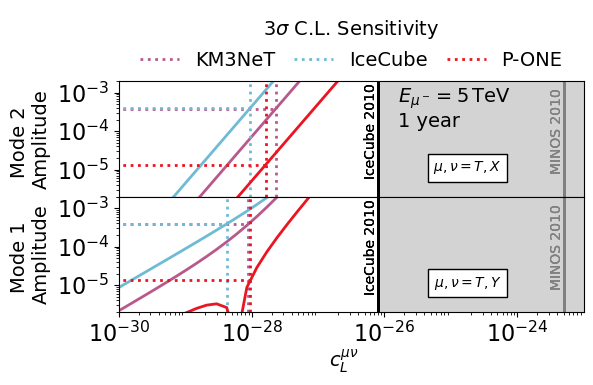

In [14]:


fig,ax = plt.subplots(2,1,sharex=True,figsize=(6,3))
plt.subplots_adjust(wspace=0, hspace=0)

fig.supxlabel(r"$c_L^{\mu \nu}$",fontsize=14,y=-0.1)
# ax[0].plot([],[],color="black",ls="-",label="IceCube 2010")
# ax[0].plot([],[],color="gray",ls="-",label="MINOS 2010")
pos1 = 0
for exp in experiment_list:
    amp_upper_limit = exp_sensitivities[(exp,mode)][sens_level]
    ax[0].plot([],[],color=color_list[exp],ls=":",label=experiment_names[exp])
    for pos2 in [1,2]:
        mode = 1 if pos2==2 else 2
        ax[pos2-1].set_ylabel("Mode %d \nAmplitude"%mode,fontsize=14)
        amps_per_cL = [cL_amps[(exp,pos1,pos2,cL)][mode] for cL in cL_range]
        if (amps_per_cL[-1]/amps_per_cL[0] < 10): continue
        ax[pos2-1].plot(cL_range,amps_per_cL,color=color_list[exp])
        plot_upper_limit(amp_upper_limit,cL_range,amps_per_cL,ax[pos2-1],color_list[exp])

        # IceCube limits 
        if (pos1,pos2) in IC_upper_limit_cL.keys():
            ax[pos2-1].plot([IC_upper_limit_cL[(pos1,pos2)],IC_upper_limit_cL[(pos1,pos2)]],
                           [amp_min,amp_max],color="black",ls="-")
            ax[pos2-1].fill_betweenx([amp_min,amp_max],
                                    x1=IC_upper_limit_cL[(pos1,pos2)],
                                    x2=cL_max,
                                    color="lightgray")
            ax[pos2-1].text(IC_upper_limit_cL[(pos1,pos2)],1e-4,"IceCube 2010",
                            horizontalalignment='right', verticalalignment='center', 
                            color="black",rotation=90)
        # MINOS limits 
        if (pos1,pos2) in MINOS_upper_limit_cL.keys():
            ax[pos2-1].plot([MINOS_upper_limit_cL[(pos1,pos2)],MINOS_upper_limit_cL[(pos1,pos2)]],
                           [amp_min,amp_max],color="gray",ls="-")
            ax[pos2-1].fill_betweenx([amp_min,amp_max],
                                    x1=MINOS_upper_limit_cL[(pos1,pos2)],
                                    x2=cL_max,
                                    color="lightgray")
            
            ax[pos2-1].text(MINOS_upper_limit_cL[(pos1,pos2)],1e-4,"MINOS 2010",
                            horizontalalignment='right', verticalalignment='center', 
                            color="gray",rotation=90)
        if exp=="IC":
            ax[pos2-1].text(0.75,0.25,r"$\mu,\nu = %s,%s$"%(lorentz_index[pos1],lorentz_index[pos2]),
                               horizontalalignment='center', verticalalignment='center', 
                               transform=ax[pos2-1].transAxes,
                               bbox=dict(facecolor='white',edgecolor="black"))
            ax[pos2-1].loglog()
            ax[pos2-1].set_xlim(cL_range[0],cL_max)
            ax[pos2-1].set_ylim(amp_min,amp_max)
ax[0].legend(fontsize=14, ncol=3, columnspacing=1, frameon=False,
            loc='upper center', bbox_to_anchor=(0.5, 1.7),
            title=r"$3\sigma$ C.L. Sensitivity")
ax[0].set_xlim(1e-30,1e-23)
ax[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))
ax[0].text(.6, .85, r"$E_{\mu^-} = %d\,{\rm TeV}$"%(Emuon/1e3), ha='left', va='center', transform=ax[0].transAxes,fontsize=14)
if nYears==1: ax[0].text(.6, .65, r"%d year"%(nYears), ha='left', va='center', transform=ax[0].transAxes,fontsize=14)
else: ax[0].text(.6, .65, r"%d years"%(nYears), ha='left', va='center', transform=ax[0].transAxes,fontsize=14)
plt.savefig("figures/%dTeV/LV_cL_mode2_small.pdf"%(Emuon/1e3),dpi=100,bbox_inches='tight')
plt.show()

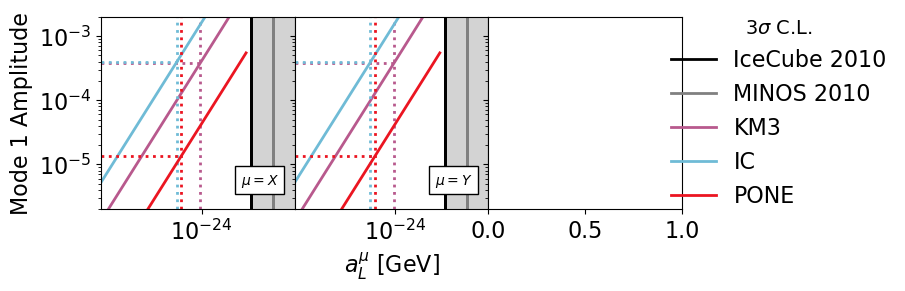

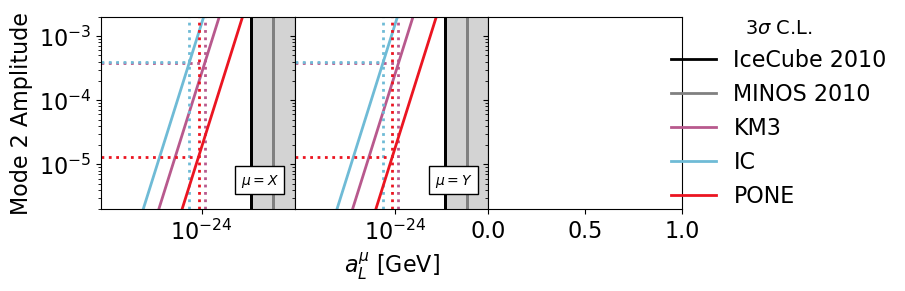

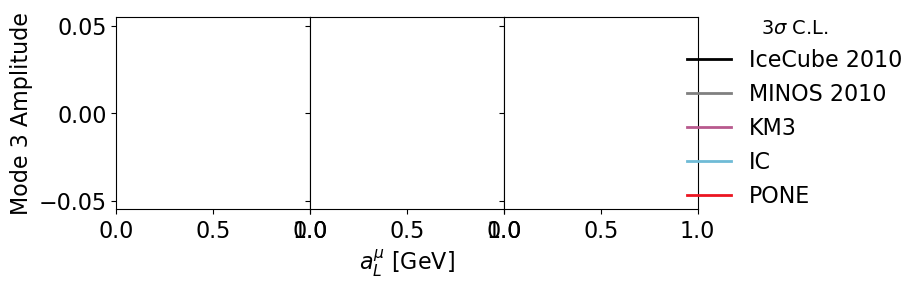

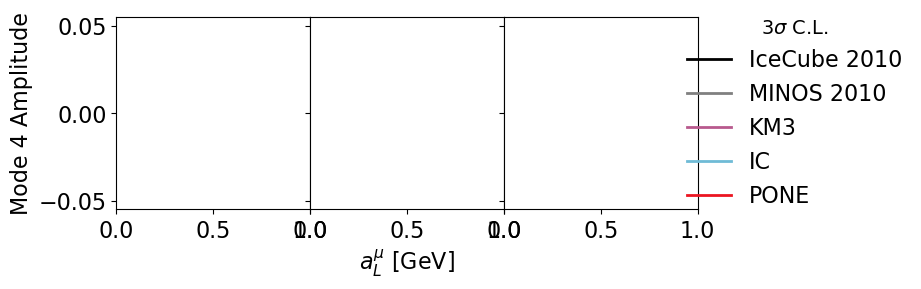

/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_11096/869704148.py:71: RuntimeWarning: invalid value encountered in scalar divide
  if (amps_per_cL[-1]/amps_per_cL[0] < 100): continue
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_11096/884583933.py:5: RuntimeWarning: divide by zero encountered in log10
  coeff_interp = interp1d(np.log10(amp_points),np.log10(coeff_points))


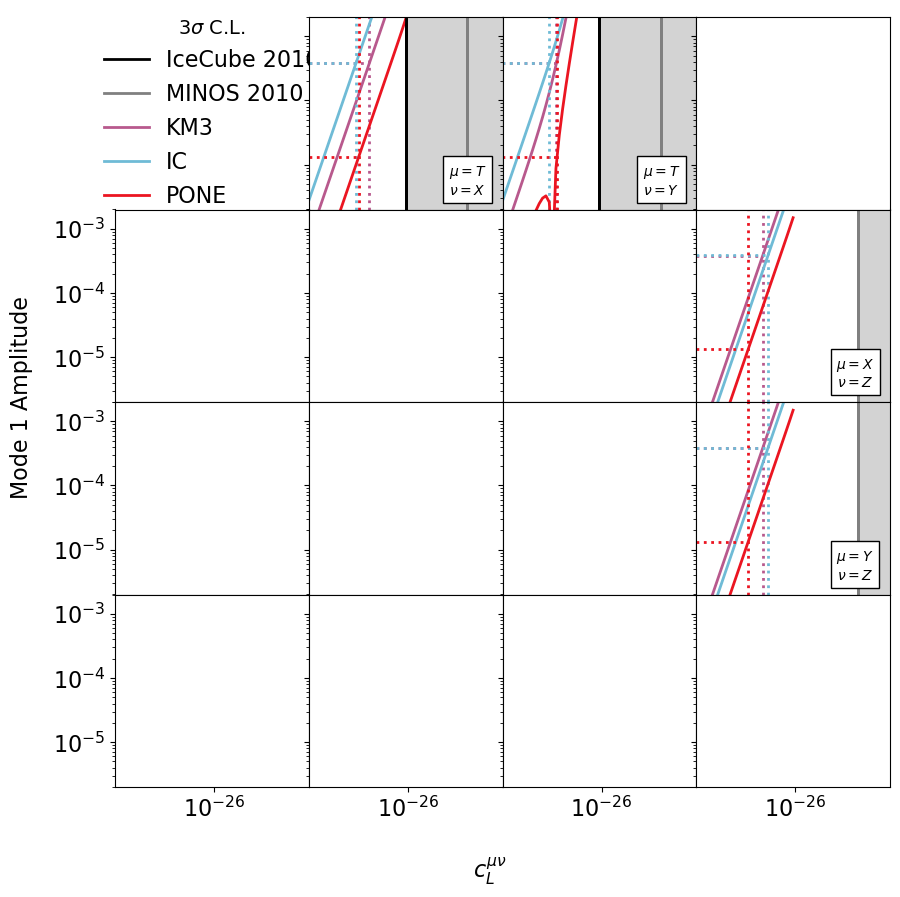

/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_11096/869704148.py:71: RuntimeWarning: invalid value encountered in scalar divide
  if (amps_per_cL[-1]/amps_per_cL[0] < 100): continue
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_11096/884583933.py:5: RuntimeWarning: divide by zero encountered in log10
  coeff_interp = interp1d(np.log10(amp_points),np.log10(coeff_points))


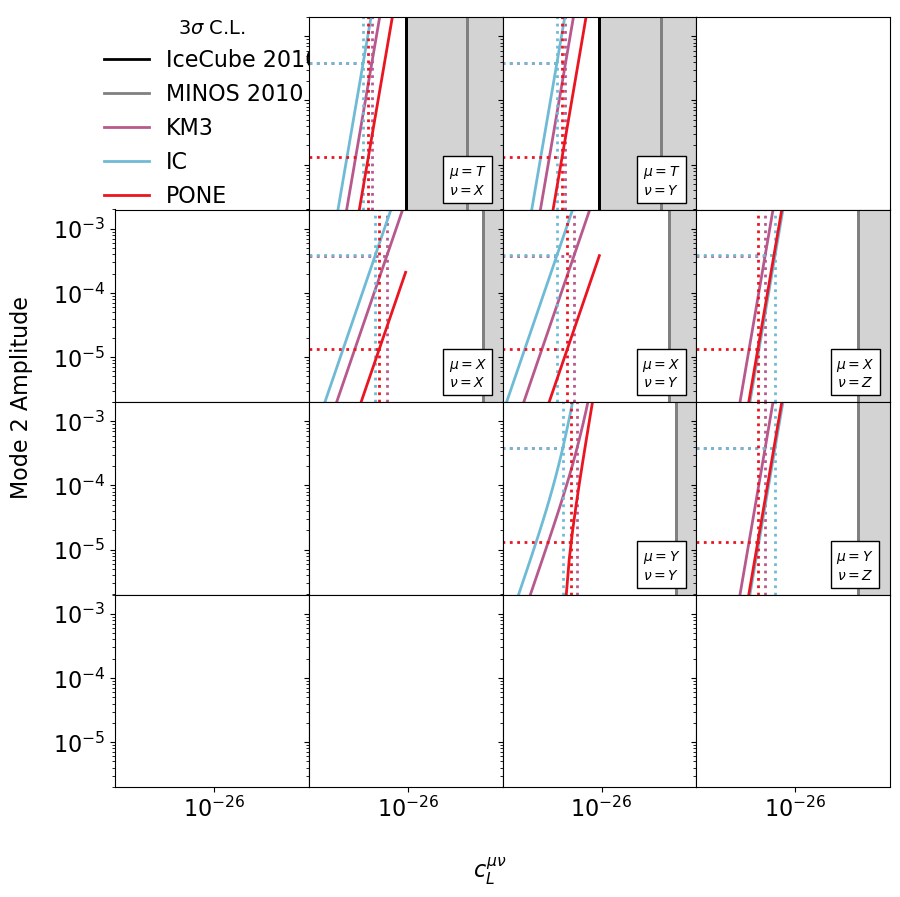

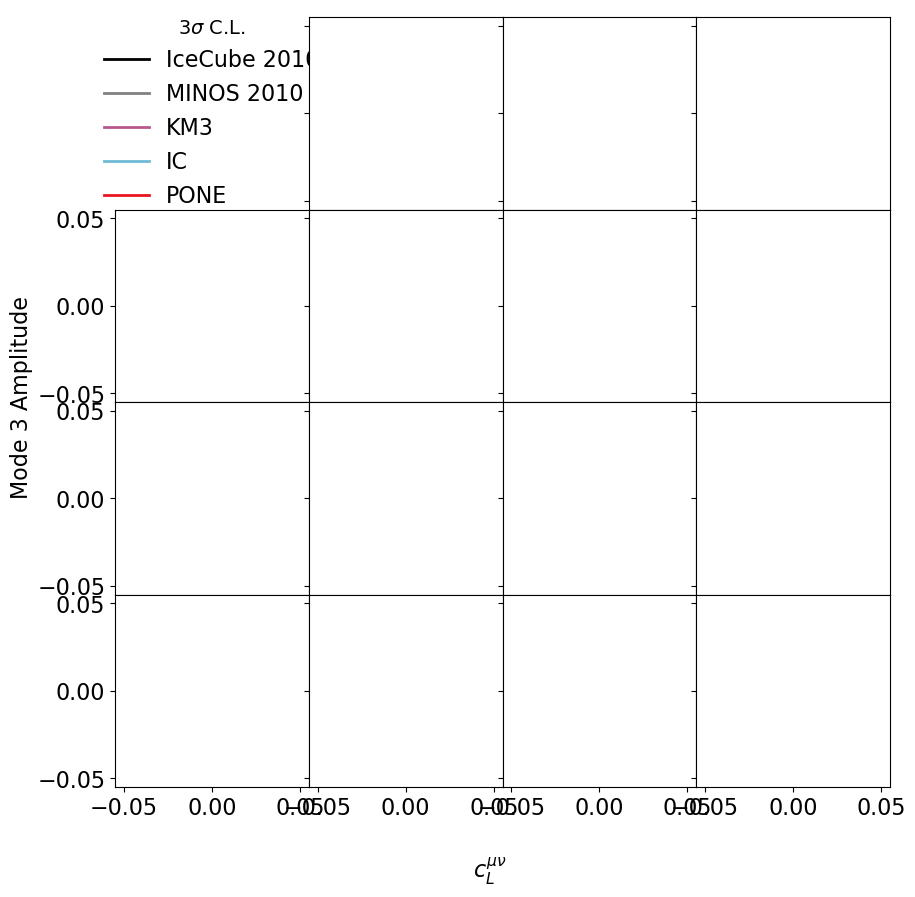

/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_11096/869704148.py:71: RuntimeWarning: invalid value encountered in scalar divide
  if (amps_per_cL[-1]/amps_per_cL[0] < 100): continue
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_11096/884583933.py:5: RuntimeWarning: divide by zero encountered in log10
  coeff_interp = interp1d(np.log10(amp_points),np.log10(coeff_points))


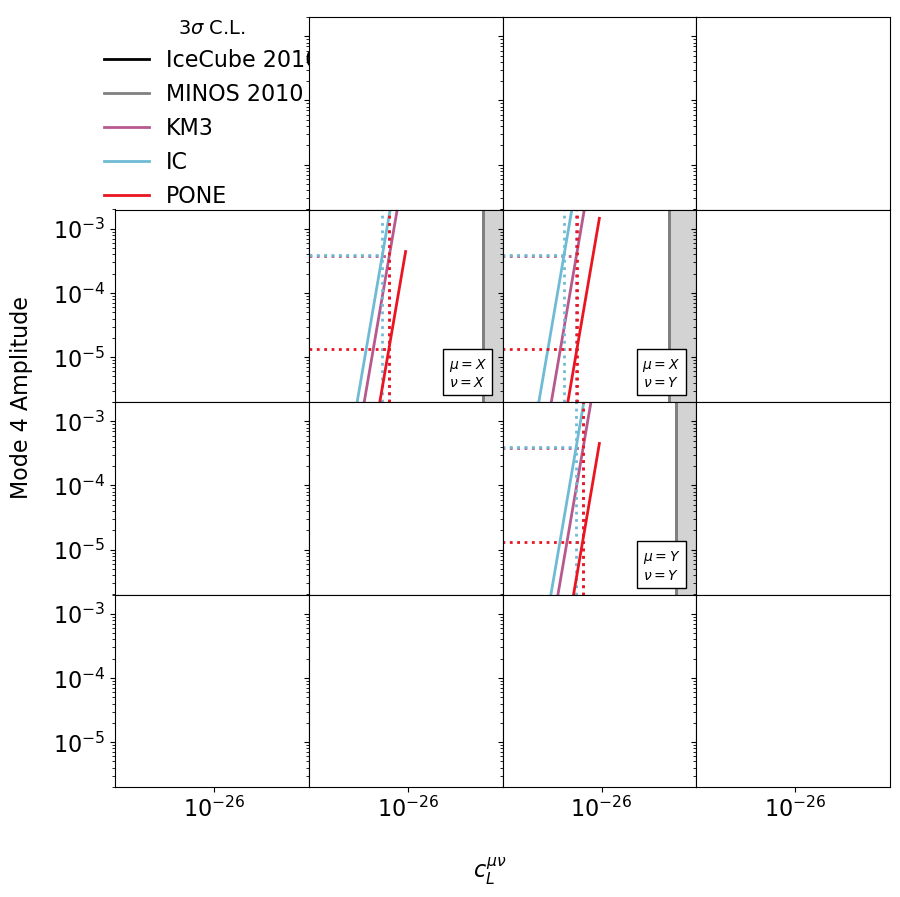

In [15]:
modes = [1,2,3,4]

aL_constraints = {exp:{mode:np.zeros(4) for mode in modes} for exp in experiment_list}
cL_constraints = {exp:{mode:np.zeros((4,4)) for mode in modes} for exp in experiment_list}

for mode in modes:
    fig,ax = plt.subplots(1,4,sharey=True,figsize=(10,2.5))
    plt.subplots_adjust(wspace=0)
    ax[-1].axis("Off")
    ax[0].set_ylabel("Mode %d Amplitude"%mode,fontsize=16)
    ax[1].set_xlabel(r"$a_L^\mu$ [GeV]",fontsize=16)
    ax[-1].plot([],[],color="black",ls="-",label="IceCube 2010")
    ax[-1].plot([],[],color="gray",ls="-",label="MINOS 2010")
    for exp in experiment_list:
        amp_upper_limit = exp_sensitivities[(exp,mode)][sens_level]
        ax[-1].plot([],[],color=color_list[exp],label=exp)
        for pos in [1,2,3]:
            amps_per_aL = [aL_amps[(exp,pos,aL)][mode] for aL in aL_range]
            if (amps_per_aL[-1]/amps_per_cL[0] < 10): continue
            ax[pos-1].plot(aL_range,amps_per_aL,color=color_list[exp])
            aL_constraints[exp][mode][pos] = plot_upper_limit(amp_upper_limit,aL_range,amps_per_aL,ax[pos-1],color_list[exp])
            
            # IceCube limits
            if pos in IC_upper_limit_aL.keys():
                ax[pos-1].plot([IC_upper_limit_aL[pos],IC_upper_limit_aL[pos]],
                               [amp_min,amp_max],color="black",ls="-")
                ax[pos-1].fill_betweenx([amp_min,amp_max],
                                        x1=IC_upper_limit_aL[pos],
                                        x2=aL_max,
                                        color="lightgray")
            # MINOS limits
            if pos in MINOS_upper_limit_aL.keys():
                ax[pos-1].plot([MINOS_upper_limit_aL[pos],MINOS_upper_limit_aL[pos]],
                               [amp_min,amp_max],color="gray",ls="-")
                ax[pos-1].fill_betweenx([amp_min,amp_max],
                                        x1=MINOS_upper_limit_aL[pos],
                                        x2=aL_max,
                                        color="lightgray")
                
            if exp=="IC":
                ax[pos-1].text(0.82,0.15,r"$\mu = %s$"%lorentz_index[pos],
                           horizontalalignment='center', verticalalignment='center', 
                           transform=ax[pos-1].transAxes,
                           bbox=dict(facecolor='white',edgecolor="black"))
                ax[pos-1].loglog()
                ax[pos-1].set_xlim(aL_range[0],aL_max)
                ax[pos-1].set_ylim(amp_min,amp_max)
    ax[-1].legend(title=r"$3\sigma$ C.L.",loc="center")
    #plt.tight_layout()
    plt.savefig("figures/%dTeV/LV_aL_mode%d.pdf"%(Emuon/1e3,mode),dpi=100,bbox_inches='tight')
    plt.show()




for mode in [1,2,3,4]:
    fig,ax = plt.subplots(4,4,sharey=True,sharex=True,figsize=(10,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    ax[0,0].axis("off")
    fig.supylabel("Mode %d Amplitude"%mode,fontsize=16)
    fig.supxlabel(r"$c_L^{\mu \nu}$",fontsize=16)
    ax[0,0].plot([],[],color="black",ls="-",label="IceCube 2010")
    ax[0,0].plot([],[],color="gray",ls="-",label="MINOS 2010")
    for exp in experiment_list:
        amp_upper_limit = exp_sensitivities[(exp,mode)][sens_level]
        ax[0,0].plot([],[],color=color_list[exp],label=exp)
        for pos1 in range(4):
            for pos2 in range(4):
                if pos1==0 and pos2==0: continue
                amps_per_cL = [cL_amps[(exp,pos1,pos2,cL)][mode] for cL in cL_range]
                if (amps_per_cL[-1]/amps_per_cL[0] < 100): continue
                try:
                    ax[pos1,pos2].plot(cL_range,amps_per_cL,color=color_list[exp])
                    cL_constraints[exp][mode][pos1,pos2] = plot_upper_limit(amp_upper_limit,cL_range,amps_per_cL,ax[pos1,pos2],color_list[exp])
    
                    # IceCube limits 
                    if (pos1,pos2) in IC_upper_limit_cL.keys():
                        ax[(pos1,pos2)].plot([IC_upper_limit_cL[(pos1,pos2)],IC_upper_limit_cL[(pos1,pos2)]],
                                       [amp_min,amp_max],color="black",ls="-")
                        ax[(pos1,pos2)].fill_betweenx([amp_min,amp_max],
                                                x1=IC_upper_limit_cL[(pos1,pos2)],
                                                x2=cL_max,
                                                color="lightgray")
                    # MINOS limits 
                    if (pos1,pos2) in MINOS_upper_limit_cL.keys():
                        ax[(pos1,pos2)].plot([MINOS_upper_limit_cL[(pos1,pos2)],MINOS_upper_limit_cL[(pos1,pos2)]],
                                       [amp_min,amp_max],color="gray",ls="-")
                        ax[(pos1,pos2)].fill_betweenx([amp_min,amp_max],
                                                x1=MINOS_upper_limit_cL[(pos1,pos2)],
                                                x2=cL_max,
                                                color="lightgray")
                        
                    if exp=="IC":
                        ax[pos1,pos2].text(0.82,0.15,r"$\mu = %s$"%lorentz_index[pos1]+"\n"+r"$\nu = %s$"%lorentz_index[pos2],
                                           horizontalalignment='center', verticalalignment='center', 
                                           transform=ax[pos1,pos2].transAxes,
                                           bbox=dict(facecolor='white',edgecolor="black"))
                        ax[pos1,pos2].loglog()
                        ax[pos1,pos2].set_xlim(cL_range[0],cL_max)
                        ax[pos1,pos2].set_ylim(amp_min,amp_max)
                except:
                    pass
    ax[0,0].legend(title=r"$3\sigma$ C.L.",loc="center")
    plt.savefig("figures/%dTeV/LV_cL_mode%d.pdf"%(Emuon/1e3,mode),dpi=100,bbox_inches='tight')
    plt.show()

In [16]:
print("Coefficient",end=" & ")
for exp in experiment_list:
    print(experiment_names[exp],end=" & ")
print("Current Limit",end=" \\\\\n")

if Emuon==5e3: cNorm = 28
elif Emuon==20e3: cNorm = 29

# aL limits
for pos in [1,2]:
    print(r"$a_L^%s / 10^{-25}\,{\rm GeV}$"%lorentz_index[pos], end = " & ")
    for exp in experiment_list:
        best_lim = np.inf
        best_mode=0
        for mode in modes:
            lim = aL_constraints[exp][mode][pos]
            if lim<=0: continue
            if lim<best_lim:
                best_lim=lim
                best_mode=mode
        if best_lim!=np.inf: print("%1.1f (%d)"%(best_lim/1e-25,best_mode),end=" & ")
        else: print("N/A",end=" & ")
    current_best_lim = np.inf
    best_exp = ""
    if pos in MINOS_upper_limit_aL:
        if MINOS_upper_limit_aL[pos] < current_best_lim:
            current_best_lim = MINOS_upper_limit_aL[pos]
            best_exp = "MINOS"
    if pos in IC_upper_limit_aL:
        if IC_upper_limit_aL[pos] < current_best_lim:
            current_best_lim = IC_upper_limit_aL[pos]
            best_exp = "IceCube"
    if current_best_lim != np.inf: 
        print("$%s$ (%s)"%(latex_float(current_best_lim/1e-25),best_exp),end=" \\\\\n ")
    else:
        print("N/A",end=" \\\\\n ")

# aL limits
for pos1 in [0,1,2,3]:
    for pos2 in [0,1,2,3]:
        if (pos1,pos2) in [(2,1),
                           (3,1),
                           (3,2),
                           (3,3),
                           (0,0),
                           (0,3),
                           (1,0),
                           (2,0),
                           (3,0)]:
            continue
        print(r"$c_L^{%s%s} / 10^{-%d}$"%(lorentz_index[pos1],lorentz_index[pos2],cNorm), end = " & ")
        for exp in experiment_list:
            best_lim = np.inf
            best_mode=0
            for mode in modes:
                lim = cL_constraints[exp][mode][pos1,pos2]
                if lim<=0: continue
                if lim<best_lim:
                    best_lim=lim
                    best_mode=mode
            if best_lim!=np.inf: print("%1.1f (%d)"%(best_lim/10**-cNorm,best_mode),end=" & ")
            else: print("N/A",end=" & ")
        current_best_lim = np.inf
        best_exp = ""
        if (pos1,pos2) in MINOS_upper_limit_cL:
            if MINOS_upper_limit_cL[(pos1,pos2)] < current_best_lim:
                current_best_lim = MINOS_upper_limit_cL[(pos1,pos2)]
                best_exp = r"\cite{MINOS:2010kat}"
        if (pos1,pos2) in IC_upper_limit_cL:
            if IC_upper_limit_cL[(pos1,pos2)] < current_best_lim:
                current_best_lim = IC_upper_limit_cL[(pos1,pos2)]
                best_exp = r"\cite{IceCube:2010fyu}"
        if current_best_lim != np.inf: 
            print("$%s$ (%s)"%(latex_float(current_best_lim/10**-cNorm),best_exp),end=" \\\\\n ")
        else:
            print("N/A",end=" \\\\\n ")

Coefficient & KM3NeT & IceCube & P-ONE & Current Limit \\
$a_L^X / 10^{-25}\,{\rm GeV}$ & 9.2 (1) & 2.4 (1) & 3.1 (1) & $1.7 \times 10^{2}$ (IceCube) \\
 $a_L^Y / 10^{-25}\,{\rm GeV}$ & 9.2 (1) & 2.4 (1) & 3.1 (1) & $1.7 \times 10^{2}$ (IceCube) \\
 $c_L^{TX} / 10^{-28}$ & 1.8 (1) & 0.5 (1) & 0.6 (1) & $79$ (\cite{IceCube:2010fyu}) \\
 $c_L^{TY} / 10^{-28}$ & 0.9 (1) & 0.4 (1) & 1.0 (1) & $79$ (\cite{IceCube:2010fyu}) \\
 $c_L^{XX} / 10^{-28}$ & 11.1 (2) & 3.4 (2) & 5.0 (2) & $2.5 \times 10^{5}$ (\cite{MINOS:2010kat}) \\
 $c_L^{XY} / 10^{-28}$ & 5.6 (2) & 0.9 (2) & 2.8 (2) & $1.2 \times 10^{5}$ (\cite{MINOS:2010kat}) \\
 $c_L^{XZ} / 10^{-28}$ & 3.3 (1) & 5.8 (1) & 0.7 (1) & $7 \times 10^{4}$ (\cite{MINOS:2010kat}) \\
 $c_L^{YY} / 10^{-28}$ & 7.6 (2) & 1.7 (2) & 4.2 (2) & $2.4 \times 10^{5}$ (\cite{MINOS:2010kat}) \\
 $c_L^{YZ} / 10^{-28}$ & 3.3 (1) & 5.8 (1) & 0.7 (1) & $7 \times 10^{4}$ (\cite{MINOS:2010kat}) \\
 